In [1]:
import sqlite3

In [2]:
import pandas as pd

In [25]:
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

## Database Structure

```
[ProgramCategory]
- [ProgramID]
- [Program]

[RegionsServed]
- [RegionID]
- [Region]

[SexTable]
- [SexID]
- [SexValue]

[LivingSit]
- [LivingID]
- [Situation]

[Education]
- [EducationID]
- [Status]

[Household]
- [HouseID]
- [Composition]

[Employment]
- [EmploymentID]
- [Status]

[MentalIllness]
- [IllnessID]
- [IllnessStatus]

[Patients]
- [PatientID]
- [ProgramID]
- [RegionID]
- [SexID]
- [LivingID]
- [EducationID]
- [HouseID]
- [EmploymentID]
- [IllnessID]
```

In [4]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
SELECT *
FROM Education
'''
df = pd.read_sql_query(sql_statement, conn_normalized)
print(df)
conn_normalized.close

   EducationID                        Status
0            1    COLLEGE OR GRADUATE DEGREE
1            2  MIDDLE SCHOOL TO HIGH SCHOOL
2            3           NO FORMAL EDUCATION
3            4                         OTHER
4            5          PRE-K TO FIFTH GRADE
5            6                  SOME COLLEGE
6            7                       UNKNOWN


<function Connection.close>

### Total Incoming Patient in the hospital and their employment status

                                     Employment_Type   COUNT
0                                           EMPLOYED   41962
1                                 NON-PAID/VOLUNTEER    1095
2  NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...  127643
3                       UNEMPLOYED: LOOKING FOR WORK   21153
4                          UNKNOWN EMPLOYMENT STATUS   14759


[Text(0.5, 1.0, 'All Patient and employment status')]

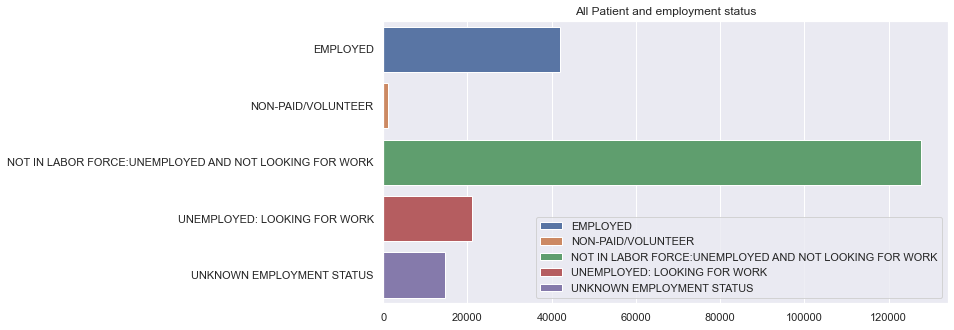

In [151]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
SELECT 
    e.Status as Employment_Type,
    COUNT(p.PatientID) as COUNT 
    
FROM 
    Patients p
    JOIN Employment e
        ON p.EmploymentID = e.EmploymentID
GROUP BY 
    e.Status

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close


empType = list(map(lambda row: row[0].strip(), df))
empTypeCount = list(map(lambda row: row[1], df))

sns.set(rc={"figure.figsize":(8, 4)})
sns.barplot(y=empType, x=empTypeCount,hue=empType,dodge=False).set(title='All Patient and employment status')



## Created a denormalised table form all data and using it other queries

In [197]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID,
        pc.program,
        r.Region,
        s.SexValue,
        l.Situation,
        ed.Status,
        hh.Composition,
        emp.Status,
        m.IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
    )
SELECT
    *
FROM
    FullTable

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close

        PatientID      program                Region SexValue  \
0               1   OUTPATIENT     CENTRAL NY REGION   FEMALE   
1               2    INPATIENT   HUDSON RIVER REGION     MALE   
2               3   OUTPATIENT     CENTRAL NY REGION     MALE   
3               4   OUTPATIENT  NEW YORK CITY REGION   FEMALE   
4               5  RESIDENTIAL  NEW YORK CITY REGION     MALE   
...           ...          ...                   ...      ...   
206607     206608  RESIDENTIAL  NEW YORK CITY REGION     MALE   
206608     206609  RESIDENTIAL  NEW YORK CITY REGION     MALE   
206609     206610  RESIDENTIAL  NEW YORK CITY REGION   FEMALE   
206610     206611  RESIDENTIAL  NEW YORK CITY REGION   FEMALE   
206611     206612  RESIDENTIAL  NEW YORK CITY REGION   FEMALE   

                     Situation                        Status  \
0            PRIVATE RESIDENCE    COLLEGE OR GRADUATE DEGREE   
1        INSTITUTIONAL SETTING  MIDDLE SCHOOL TO HIGH SCHOOL   
2            PRIVATE RESIDE

<function Connection.close>

In [198]:
df1.head()

,PatientID,program,Region,SexValue,Situation,Status,Composition,Status:1,IllnessStatus
0,1,OUTPATIENT,CENTRAL NY REGION,FEMALE,PRIVATE RESIDENCE,COLLEGE OR GRADUATE DEGREE,COHABITATES WITH OTHERS,EMPLOYED,YES
1,2,INPATIENT,HUDSON RIVER REGION,MALE,INSTITUTIONAL SETTING,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,YES
2,3,OUTPATIENT,CENTRAL NY REGION,MALE,PRIVATE RESIDENCE,SOME COLLEGE,LIVES ALONE,EMPLOYED,YES
3,4,OUTPATIENT,NEW YORK CITY REGION,FEMALE,PRIVATE RESIDENCE,MIDDLE SCHOOL TO HIGH SCHOOL,LIVES ALONE,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,YES
4,5,RESIDENTIAL,NEW YORK CITY REGION,MALE,PRIVATE RESIDENCE,MIDDLE SCHOOL TO HIGH SCHOOL,LIVES ALONE,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,YES


In [55]:
df1.shape

(206612, 9)

## Distribution and Rank of patients with mental illness on the basic of region and gender

In [143]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID PatientID,
        pc.program program,
        r.Region Region,
        s.SexValue SexValue,
        l.Situation Situation,
        ed.Status Status,
        hh.Composition Composition,
        emp.Status Status,
        m.IllnessStatus IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
)
SELECT 
    Region,
    SexValue,
    COUNT(PatientID) Count,
    rank() OVER (PARTITION BY Region ORDER BY -COUNT(PatientID)) IllnessRegionRank
FROM
    FullTable
WHERE
    IllnessStatus = "YES"
GROUP BY
    SexValue, Region
    

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close



                  Region        SexValue  Count  IllnessRegionRank
0      CENTRAL NY REGION          FEMALE  11734                  1
1      CENTRAL NY REGION            MALE  10082                  2
2      CENTRAL NY REGION         UNKNOWN    130                  3
3      CENTRAL NY REGION  X (NON-BINARY)     34                  4
4    HUDSON RIVER REGION          FEMALE  15170                  1
5    HUDSON RIVER REGION            MALE  13742                  2
6    HUDSON RIVER REGION         UNKNOWN    125                  3
7    HUDSON RIVER REGION  X (NON-BINARY)     45                  4
8     LONG ISLAND REGION          FEMALE   8312                  1
9     LONG ISLAND REGION            MALE   7534                  2
10    LONG ISLAND REGION         UNKNOWN     63                  3
11    LONG ISLAND REGION  X (NON-BINARY)      7                  4
12  NEW YORK CITY REGION          FEMALE  54181                  1
13  NEW YORK CITY REGION            MALE  44169               

<function Connection.close>

[Text(0.5, 1.0, 'Mental Illness vs Region vs Gender')]

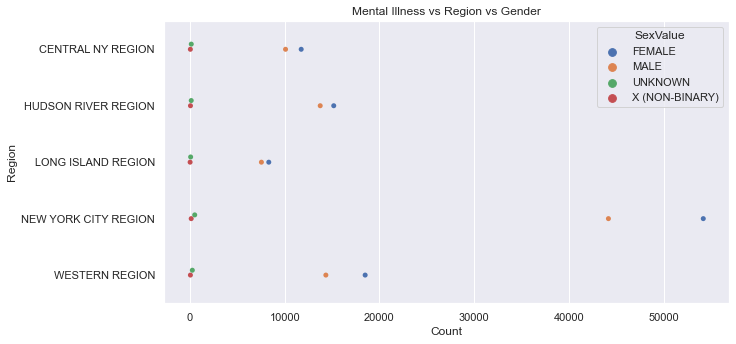

In [146]:
sns.swarmplot(x = "Count", y= "Region",hue = "SexValue", data= df1).set(title='Mental Illness vs Region vs Gender')

## Distribution in Patient WITHOUT/WITH Mental Illness

In [175]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID PatientID,
        pc.program program,
        r.Region Region,
        s.SexValue SexValue,
        l.Situation Situation,
        ed.Status Status,
        hh.Composition Composition,
        emp.Status Status,
        m.IllnessStatus IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
)
SELECT 
    SexValue,
    COUNT(PatientID) Count
FROM
    FullTable
WHERE
    IllnessStatus = "NO"
GROUP BY
    SexValue
ORDER BY 
    Count DESC
    

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close



         SexValue  Count
0            MALE   2675
1          FEMALE   2601
2         UNKNOWN     35
3  X (NON-BINARY)      9


<function Connection.close>

In [176]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID PatientID,
        pc.program program,
        r.Region Region,
        s.SexValue SexValue,
        l.Situation Situation,
        ed.Status Status,
        hh.Composition Composition,
        emp.Status Status,
        m.IllnessStatus IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
)
SELECT 
    SexValue,
    COUNT(PatientID) Count
FROM
    FullTable
WHERE
    IllnessStatus = "YES"
GROUP BY
    SexValue
ORDER BY 
    Count DESC
    

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df2 = pd.read_sql_query(sql_statement, conn_normalized)
print(df2)
conn_normalized.close



         SexValue   Count
0          FEMALE  107883
1            MALE   89865
2         UNKNOWN    1052
3  X (NON-BINARY)     247


<function Connection.close>

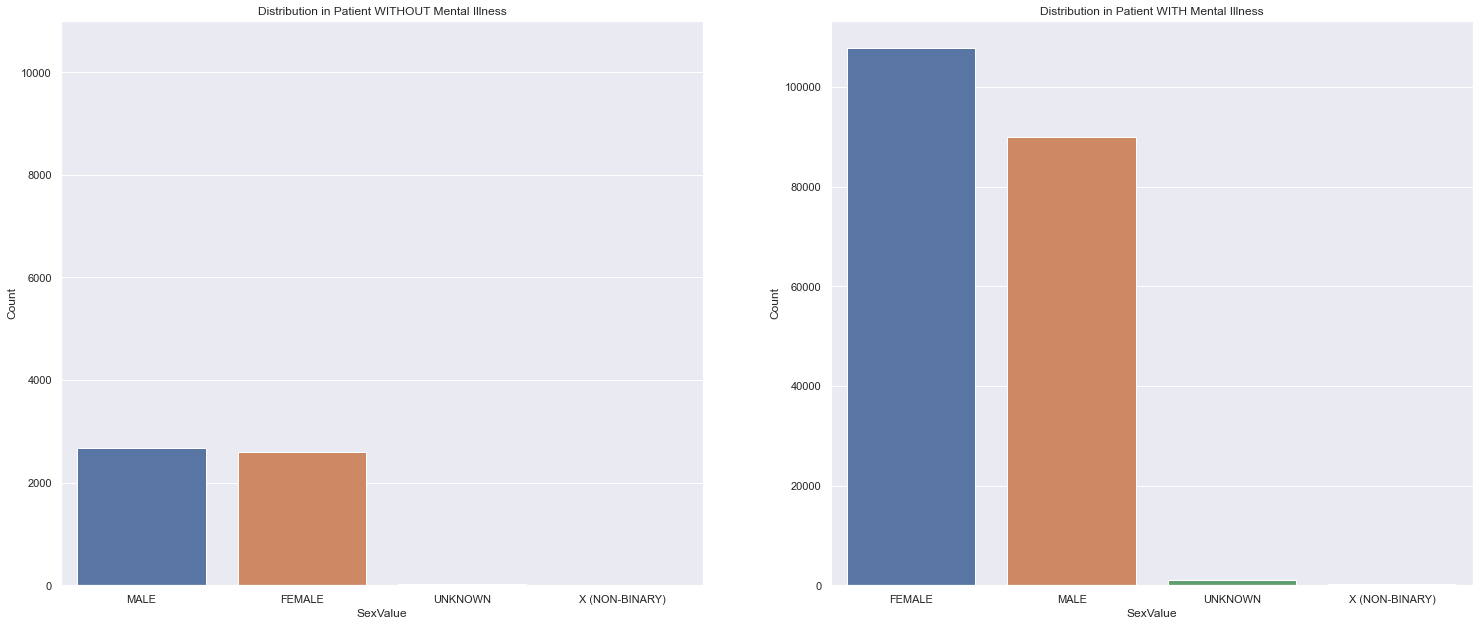

In [192]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x = df1['SexValue'], y = df1['Count'], ax=ax1).set(title='Distribution in Patient WITHOUT Mental Illness')
sns.barplot(x = df2['SexValue'], y = df2['Count'],ax=ax2).set(title='Distribution in Patient WITH Mental Illness')
ax1.set(ylim=(0,11000))
#ax2.set(ylim=(0,15000))
plt.show()

## Mental Illness wrt to living status

In [153]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID PatientID,
        pc.program program,
        r.Region Region,
        s.SexValue SexValue,
        l.Situation Situation,
        ed.Status Status,
        hh.Composition Composition,
        emp.Status Status,
        m.IllnessStatus IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
)
SELECT 
    Composition,
    COUNT(PatientID) Count
FROM
    FullTable
WHERE
    IllnessStatus = "YES"
GROUP BY
    Composition
ORDER BY 
    Count DESC
    

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close



               Composition   Count
0  COHABITATES WITH OTHERS  112835
1              LIVES ALONE   53053
2           NOT APPLICABLE   28050
3                  UNKNOWN    5109


<function Connection.close>

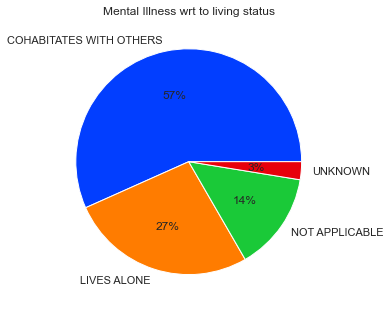

In [156]:
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(df1["Count"], labels = df1["Composition"], colors = colors, autopct='%.0f%%')
plt.title('Mental Illness wrt to living status')
plt.show()

## Mental Illness vs education

In [194]:
conn_normalized = sqlite3.connect("updated_normalized.db")
sql_statement = '''
WITH FullTable AS (
    SELECT 
        p.PatientID PatientID,
        pc.program program,
        r.Region Region,
        s.SexValue SexValue,
        l.Situation Situation,
        ed.Status Status,
        hh.Composition Composition,
        emp.Status Status,
        m.IllnessStatus IllnessStatus

    FROM 
        Patients p
        JOIN ProgramCategory pc
            ON pc.ProgramID = p.ProgramID
        JOIN RegionsServed r
            ON r.RegionID = p.RegionID
        JOIN SexTable s
            ON s.SexID = p.SexID
        JOIN LivingSit l
            ON l.LivingID = p.LivingID
        JOIN Education ed
            ON ed.EducationID = p.EducationID
        JOIN Household hh
            ON hh.HouseID = p.HouseID
        JOIN Employment emp
            ON emp.EmploymentID = p.EmploymentID
        JOIN MentalIllness m
            ON m.IllnessID = p.IllnessID
)
SELECT 
    IllnessStatus,
    Status,
    COUNT(PatientID) Count,
    rank() OVER (PARTITION BY IllnessStatus ORDER BY -COUNT(PatientID)) IllnessRegionRank
FROM
    FullTable
WHERE
    IllnessStatus IN ( "YES", "NO" )
GROUP BY
    IllnessStatus,Status

    

'''
df = execute_sql_statement(sql_statement, conn_normalized)
df1 = pd.read_sql_query(sql_statement, conn_normalized)
print(df1)
conn_normalized.close



   IllnessStatus                        Status  Count  IllnessRegionRank
0             NO  MIDDLE SCHOOL TO HIGH SCHOOL   2337                  1
1             NO          PRE-K TO FIFTH GRADE   1236                  2
2             NO                       UNKNOWN    597                  3
3             NO    COLLEGE OR GRADUATE DEGREE    591                  4
4             NO                  SOME COLLEGE    420                  5
5             NO           NO FORMAL EDUCATION    102                  6
6             NO                         OTHER     37                  7
7            YES  MIDDLE SCHOOL TO HIGH SCHOOL  98991                  1
8            YES    COLLEGE OR GRADUATE DEGREE  29539                  2
9            YES                  SOME COLLEGE  25649                  3
10           YES                       UNKNOWN  25648                  4
11           YES          PRE-K TO FIFTH GRADE  14554                  5
12           YES                         OTHER   31

<function Connection.close>

[Text(0.5, 1.0, 'Mental Illness vs education')]

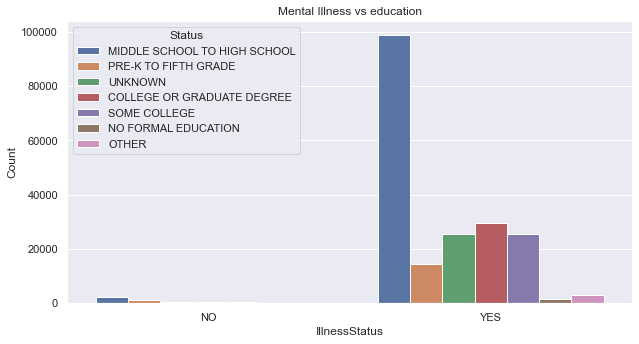

In [196]:
sns.barplot(x = "IllnessStatus", y= "Count",hue = "Status", data= df1).set(title='Mental Illness vs education')

## Conclusion:

To encapsulate, on the basis of the Dataset and the extracted insights, it is conspicuous that in the New York City Region, majority number of patients who visit hospitals(mostly females) suffer from Mental Illness. Additionally, it can be inferred that mental disorder is mainly found in people who didn’t go for higher education after school and those who do not seek to work professionally. Also, according to the dataset, patients who are accompanied in their household composition are more likely to be a victim of mental health diseases.